Примечание: это вторая часть задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

478

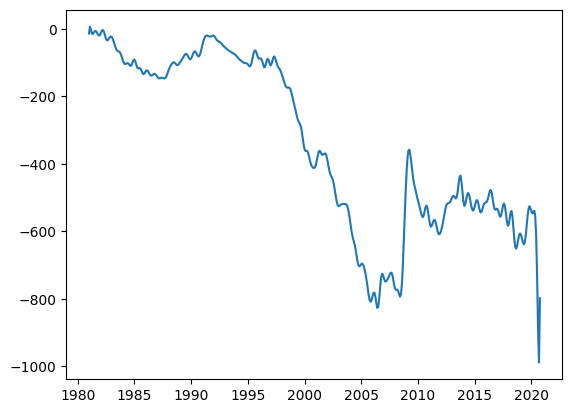

In [2]:
qrr = pd.read_csv('macro_quarterly.csv')
qrr_index = pd.to_datetime(qrr["date"], format="%d/%m/%Y")
qrr = qrr.drop(["date"], axis="columns")
qrr.index = qrr_index
qrr = qrr.asfreq("MS").interpolate(method='polynomial', order=7)
plt.plot(qrr["netexp"])
len(qrr["gdp"])

In [3]:
mth = pd.read_csv('macro_monthly.csv')
df_index = pd.to_datetime(mth["DATE"], format="%Y-%m-%d")
mth = mth.drop(["DATE"], axis="columns")
mth.index = df_index
df = mth.copy(deep=True)
for c in qrr.columns:
    df[c] = qrr[c].copy(deep=True)
#df["reer"] = df["reer"].fillna(df["reer"].mean())
#df["tcs"] = df["tcs"].fillna(df["tcs"].mean())
df = df.dropna().asfreq('W').interpolate(method='polynomial', order=1).dropna()

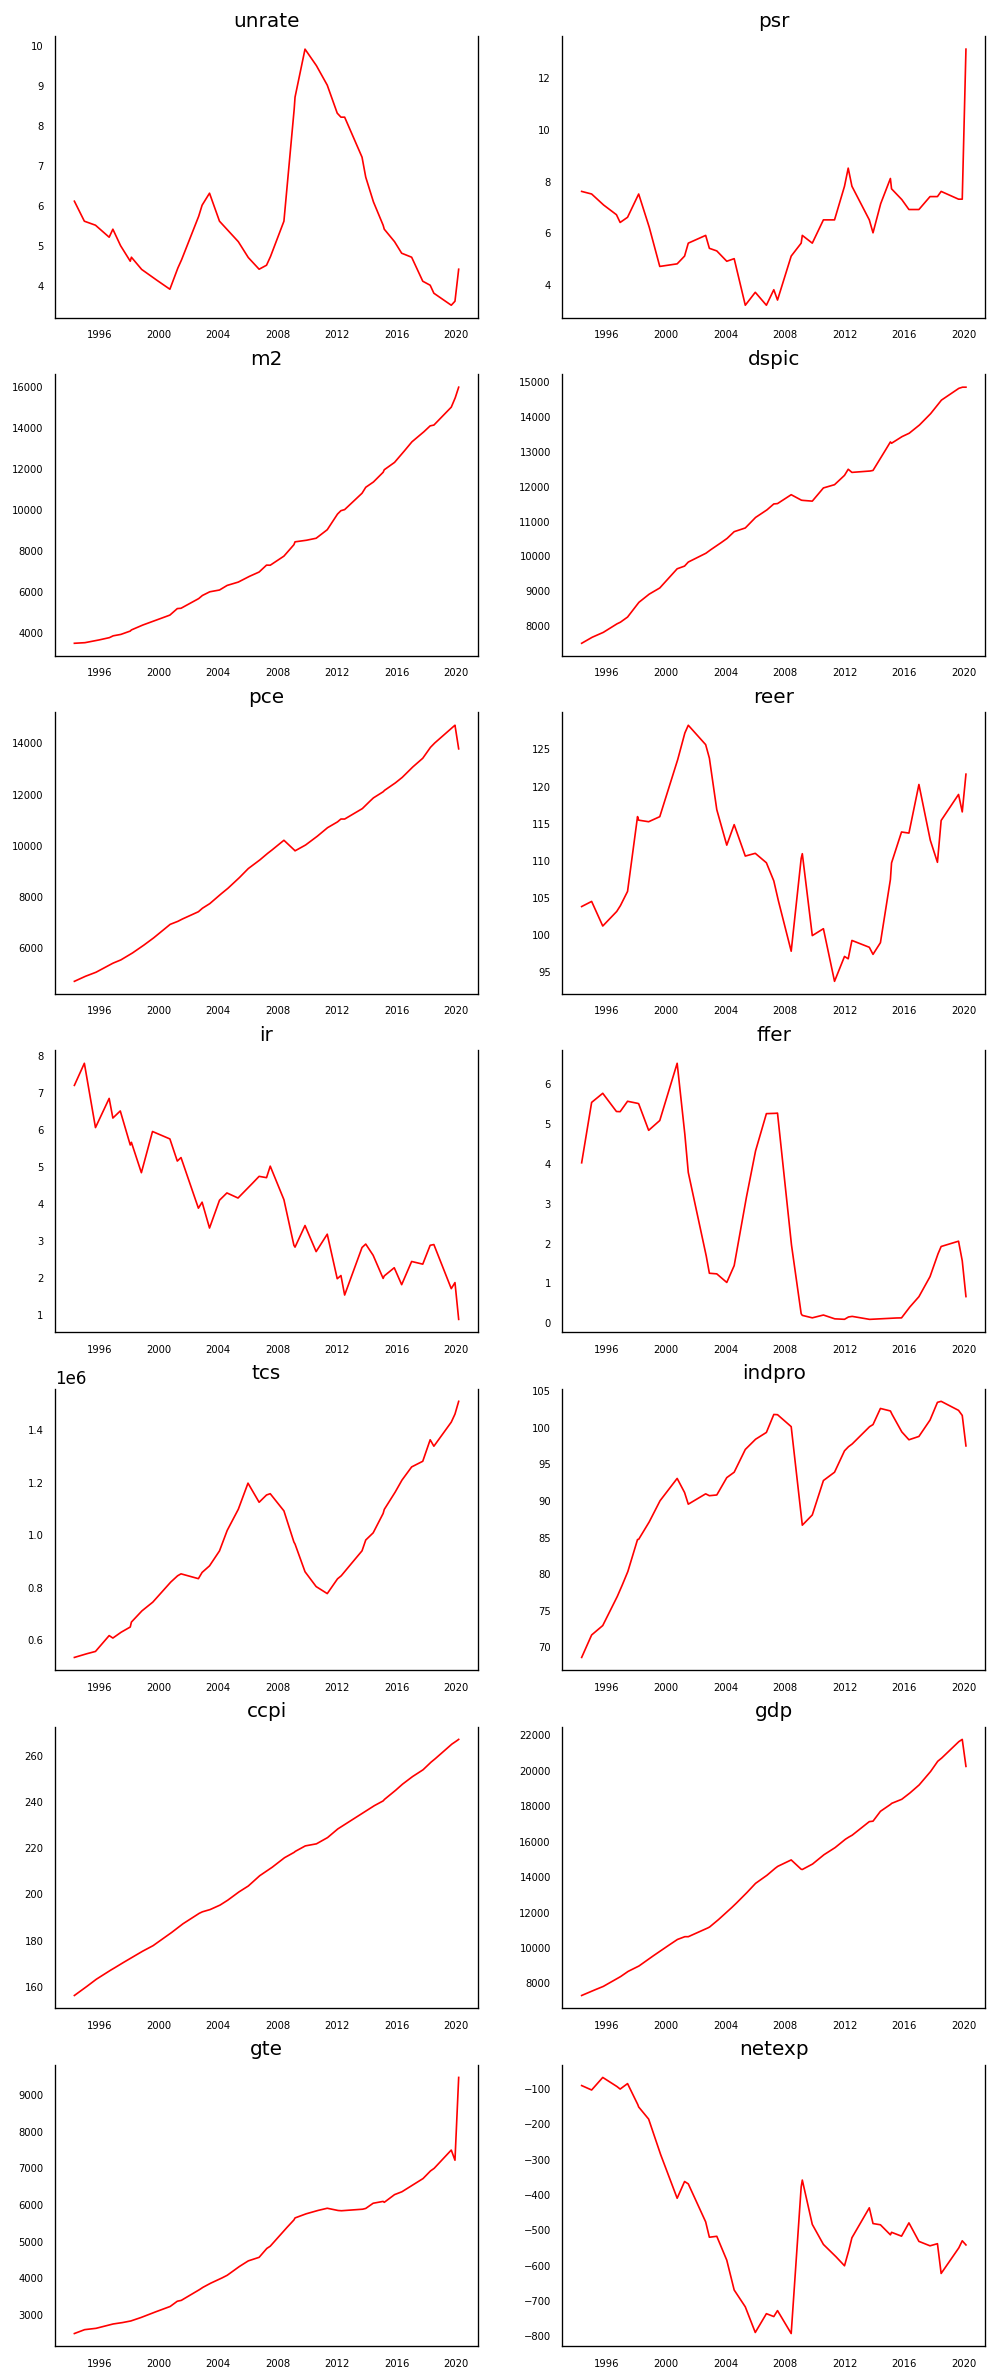

In [4]:
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=120, figsize=(10,25))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.show()

In [5]:
train = df[:int(0.9*(len(data)))]
test = df[int(0.9*(len(data))):]

In [6]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

### Нейронные сети

##### RNN

In [7]:
!pip install scikeras

In [35]:
import torch
from torch import nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [9]:
def createXY(dataset,n_past):
    #dataset = ds.values
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,:])
    return np.array(dataX),np.array(dataY)

In [10]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [ ]:
from sklearn.metrics import mean_absolute_error
import copy
def build_model(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(SimpleRNN(hout, input_shape=(npas,icol), activation='relu'))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=1e-3))
    return grid_model


min_error = None
best_params = {'npas': 1, 'hout': 2, 'p': 3}
for p in [0.05]:
    for hout in [1000, 2500]:
        for n_past in range(1, 11):
            params = {'npas': n_past*12, 'hout': hout, 'p': p}
            print("; ".join([key + ': ' + str(params[key]) for key in params.keys()]))
            npas = n_past * 12
            trainX,trainY=createXY(train,npas)
            testX,testY=createXY(pd.concat([train.iloc[-npas:,:], test]),npas)
            #grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
            grid_model = build_model(npas, hout, p)
            '''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''

            blindshot=grid_model.predict(testX)
            print("MAE without education:" + str(mean_absolute_error(blindshot, testY)))
            grid_fit = grid_model.fit(trainX,trainY,epochs=128,batch_size=512,verbose=0)
            prediction=grid_model.predict(testX)
            print("MAE with education:" + str(mean_absolute_error(prediction, testY)))
            print()
            if min_error is None or mean_absolute_error(prediction, testY) < min_error:
                best_params = {'npas': npas, 'hout': hout, 'p': p}
                min_error = mean_absolute_error(prediction, testY)
                best = copy.deepcopy(prediction)
                best_test = copy.deepcopy(testY)

npas: 12; hout: 1000; p: 0.05
2/2 [==============================] - 0s 13ms/step
MAE without education:159914.8915149821
2/2 [==============================] - 0s 10ms/step
MAE with education:2895.9995841754317

npas: 24; hout: 1000; p: 0.05
2/2 [==============================] - 0s 12ms/step
MAE without education:162120.03409374738
2/2 [==============================] - 0s 12ms/step
MAE with education:3565.4662901269553

npas: 36; hout: 1000; p: 0.05
2/2 [==============================] - 0s 15ms/step
MAE without education:178826.32706993917
2/2 [==============================] - 0s 16ms/step
MAE with education:3387.0452441573107

npas: 48; hout: 1000; p: 0.05
2/2 [==============================] - 0s 20ms/step
MAE without education:146582.1267375259
2/2 [==============================] - 0s 19ms/step
MAE with education:3466.251006144444

npas: 60; hout: 1000; p: 0.05
2/2 [==============================] - 0s 24ms/step
MAE without education:154778.74625274073
2/2 [===================

In [ ]:
#grid_search = grid_search.fit(trainX,trainY)
for key in best_params.keys():
    print(key, ': ', best_params[key], sep="")

npas: 12
hout: 1000
p: 0.05


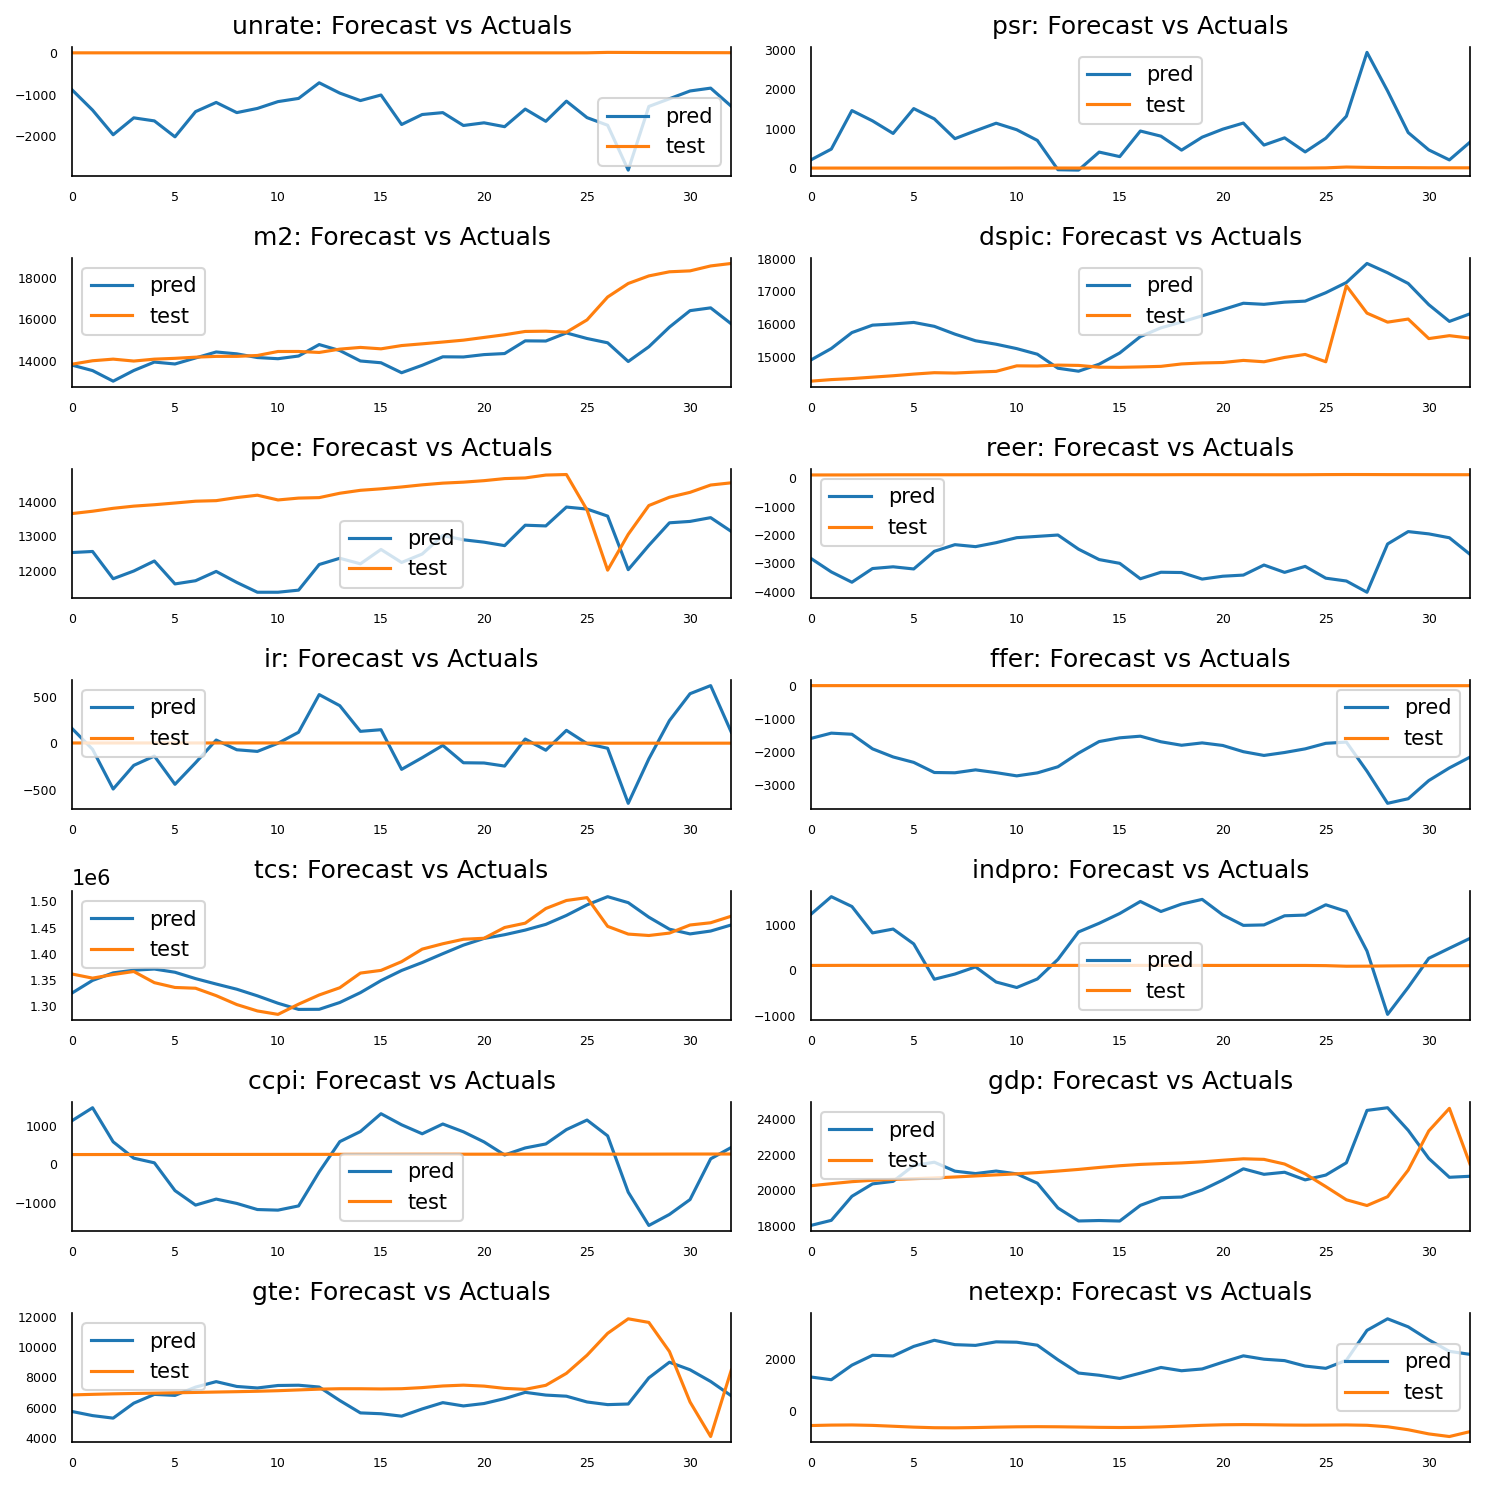

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=best[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=best_test[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Для моделей вероятность дропаута я возьму 0.05, размер внутреннего слоя - 1500 (потому что 1500 больше, чем 1000, а больше - лучше, однако 2500 я не буду брать, чтобы не училось слишком долго), npas возьму равный 72, потому что на нём также был неплохой лосс.

In [136]:
from sklearn.preprocessing import MinMaxScaler

npas = 72
hout = 2500
p=0.05
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)
trainX,trainY=createXY(train_scaled,npas)
testX,testY=createXY(np.concatenate((train_scaled[-npas:,:], test_scaled), axis=0),npas)

Epoch 1/30
18/18 [==============================] - 22s 1s/step - loss: 1.1205
Epoch 2/30
18/18 [==============================] - 19s 1s/step - loss: 0.0019
Epoch 3/30
18/18 [==============================] - 19s 1s/step - loss: 9.3879e-04
Epoch 4/30
18/18 [==============================] - 19s 1s/step - loss: 6.3367e-04
Epoch 5/30
18/18 [==============================] - 19s 1s/step - loss: 5.4246e-04
Epoch 6/30
18/18 [==============================] - 19s 1s/step - loss: 5.7230e-04
Epoch 7/30
18/18 [==============================] - 19s 1s/step - loss: 4.7864e-04
Epoch 8/30
18/18 [==============================] - 19s 1s/step - loss: 4.3330e-04
Epoch 9/30
18/18 [==============================] - 19s 1s/step - loss: 4.2929e-04
Epoch 10/30
18/18 [==============================] - 20s 1s/step - loss: 4.4188e-04
Epoch 11/30
18/18 [==============================] - 20s 1s/step - loss: 4.5629e-04
Epoch 12/30
18/18 [==============================] - 20s 1s/step - loss: 3.6769e-04
Epoch 13/

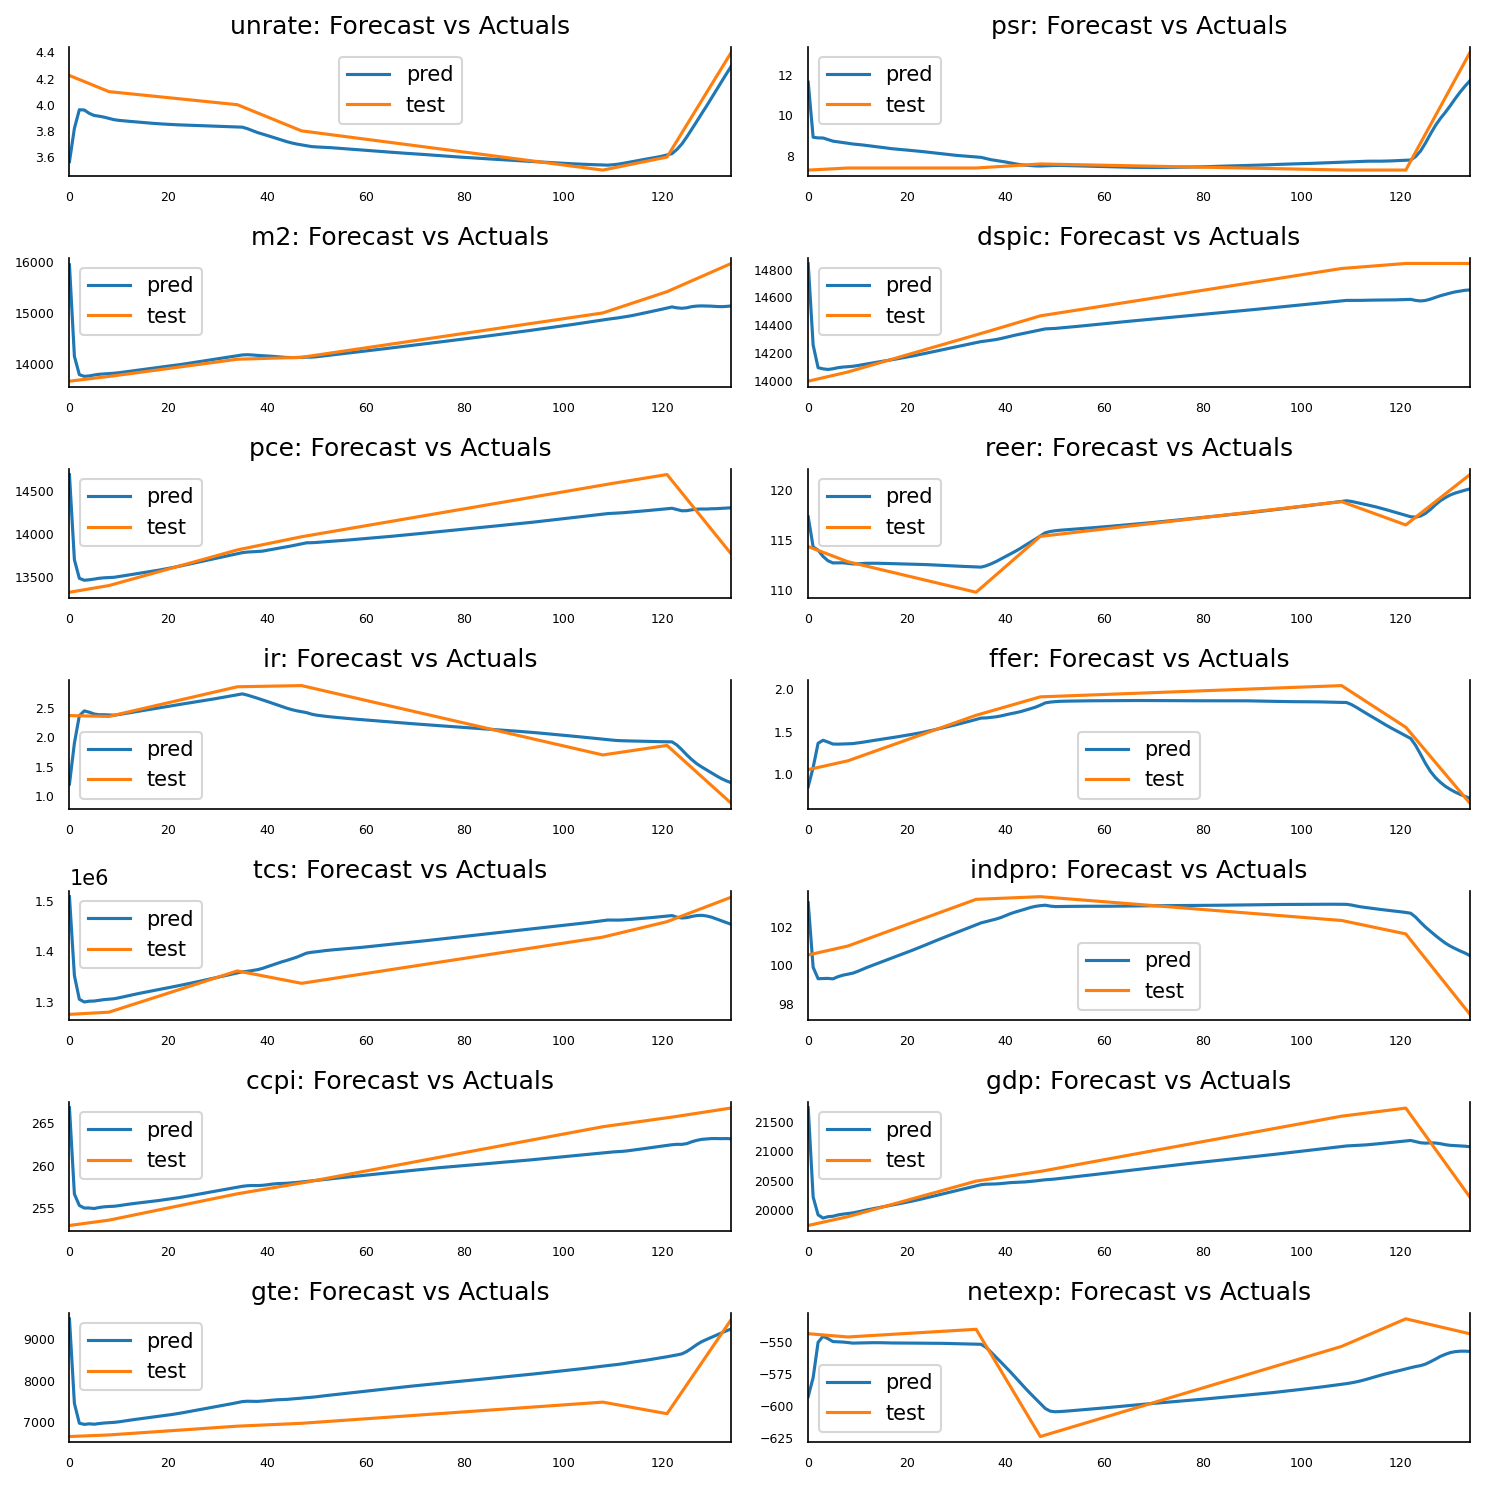

In [137]:
%%time
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Nadam


def build_model_RNN(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(SimpleRNN(hout, input_shape=(npas,icol), activation='relu'))#, return_sequences=True))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol + int((hout - icol) * 0.5)))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Nadam(learning_rate=1e-3))
    return grid_model

#grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
grid_model = build_model_RNN(npas, hout, p)
'''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''
grid_fit = grid_model.fit(trainX,trainY,epochs=30,batch_size=64,verbose=1)
prediction=grid_model.predict(testX)
testY_reverse, prediction_reverse = scaler.inverse_transform(testY), scaler.inverse_transform(prediction)
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=testY_reverse[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [138]:
validate(testY_reverse, prediction_reverse)

MSE: 118143733.21798666
RMSE: 10869.394335379808
MAE: 2407.514934521782
MAPE: 3.2505110415100673
R2: 0.4959223914302638


Рекордно низкий MAPE - значит, очень небольшое расстояние между графиками. Да и графики предиктов по своей "форме", в отличие от классических моделей, очень похожи на реальные значения (разве что, кроме, indpro, у которого в предикте медленный рост, тогда как на самом деле - медленное убывание, а также gte, у которого заметно предикт заметно больше реальных значений). Тем не менее, R2 низкий.

UPD. Добавил эпох (10 -> 30), изменил оптимизатор (Adam -> Nadam) и увеличил размерность выхода реккурентного слоя (1500 -> 2500). R2 стал немного лучше, но всё ещё так себе.

Epoch 1/30
18/18 [==============================] - 80s 4s/step - loss: 0.0688
Epoch 2/30
18/18 [==============================] - 77s 4s/step - loss: 0.0034
Epoch 3/30
18/18 [==============================] - 82s 5s/step - loss: 0.0013
Epoch 4/30
18/18 [==============================] - 82s 5s/step - loss: 8.2112e-04
Epoch 5/30
18/18 [==============================] - 82s 5s/step - loss: 5.8506e-04
Epoch 6/30
18/18 [==============================] - 77s 4s/step - loss: 4.7889e-04
Epoch 7/30
18/18 [==============================] - 77s 4s/step - loss: 3.9251e-04
Epoch 8/30
18/18 [==============================] - 77s 4s/step - loss: 3.4169e-04
Epoch 9/30
18/18 [==============================] - 81s 4s/step - loss: 3.0462e-04
Epoch 10/30
18/18 [==============================] - 86s 5s/step - loss: 2.8202e-04
Epoch 11/30
18/18 [==============================] - 90s 5s/step - loss: 3.0383e-04
Epoch 12/30
18/18 [==============================] - 89s 5s/step - loss: 2.5730e-04
Epoch 13/30
1

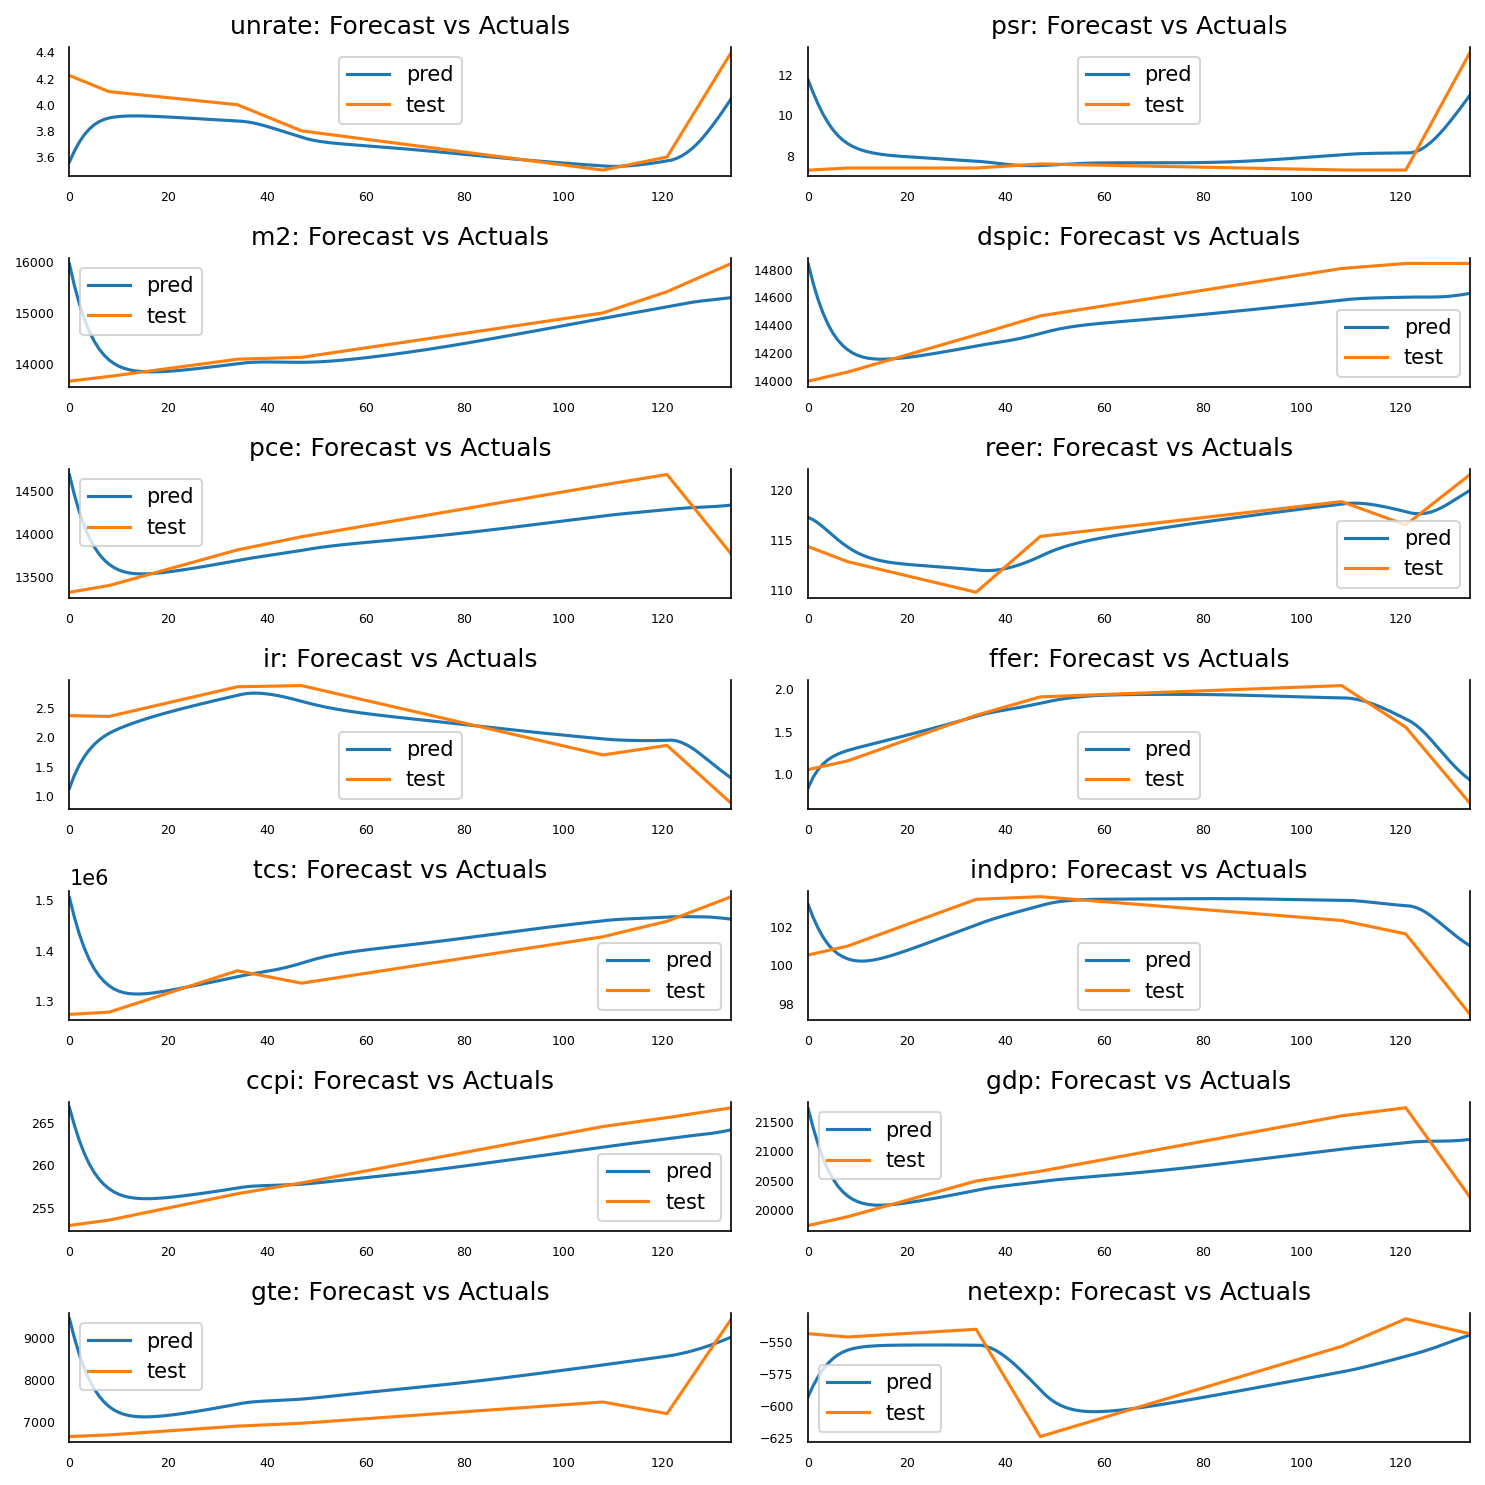

In [139]:
%%time
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Nadam

def build_model_LSTM(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(LSTM(hout, input_shape=(npas,icol), activation='relu'))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol + int((hout - icol) * 0.5)))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Nadam(learning_rate=2e-4))
    return grid_model


#grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
grid_model = build_model_LSTM(npas, hout, p)
'''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''
grid_fit = grid_model.fit(trainX,trainY,epochs=30,batch_size=64,verbose=1)
prediction=grid_model.predict(testX)
testY_reverse, prediction_reverse = scaler.inverse_transform(testY), scaler.inverse_transform(prediction)
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=testY_reverse[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [140]:
validate(testY_reverse, prediction_reverse)

MSE: 151396365.73320007
RMSE: 12304.323050586736
MAE: 2534.745629638899
MAPE: 3.5767024907148266
R2: 0.34226390481302366


Ситуация как с предыдущей моделью: MAPE маленький, "формы" графиков друг на друга похожи, но R2 низкий.

UPD. Добавил эпох (10 -> 30), изменил оптимизатор (Adam -> Nadam) и увеличил размерность выхода реккурентного слоя (1500 -> 2500). R2 стал заметно лучше, но всё ещё довольно плохо.

Epoch 1/30
18/18 [==============================] - 63s 3s/step - loss: 0.0587
Epoch 2/30
18/18 [==============================] - 63s 3s/step - loss: 7.3800e-04
Epoch 3/30
18/18 [==============================] - 62s 3s/step - loss: 3.2496e-04
Epoch 4/30
18/18 [==============================] - 62s 3s/step - loss: 2.1271e-04
Epoch 5/30
18/18 [==============================] - 61s 3s/step - loss: 1.7828e-04
Epoch 6/30
18/18 [==============================] - 63s 3s/step - loss: 1.9792e-04
Epoch 7/30
18/18 [==============================] - 61s 3s/step - loss: 1.6321e-04
Epoch 8/30
18/18 [==============================] - 61s 3s/step - loss: 1.9341e-04
Epoch 9/30
18/18 [==============================] - 62s 3s/step - loss: 3.7088e-04
Epoch 10/30
18/18 [==============================] - 61s 3s/step - loss: 1.9660e-04
Epoch 11/30
18/18 [==============================] - 64s 4s/step - loss: 3.0166e-04
Epoch 12/30
18/18 [==============================] - 64s 4s/step - loss: 1.3947e-04
Epoch

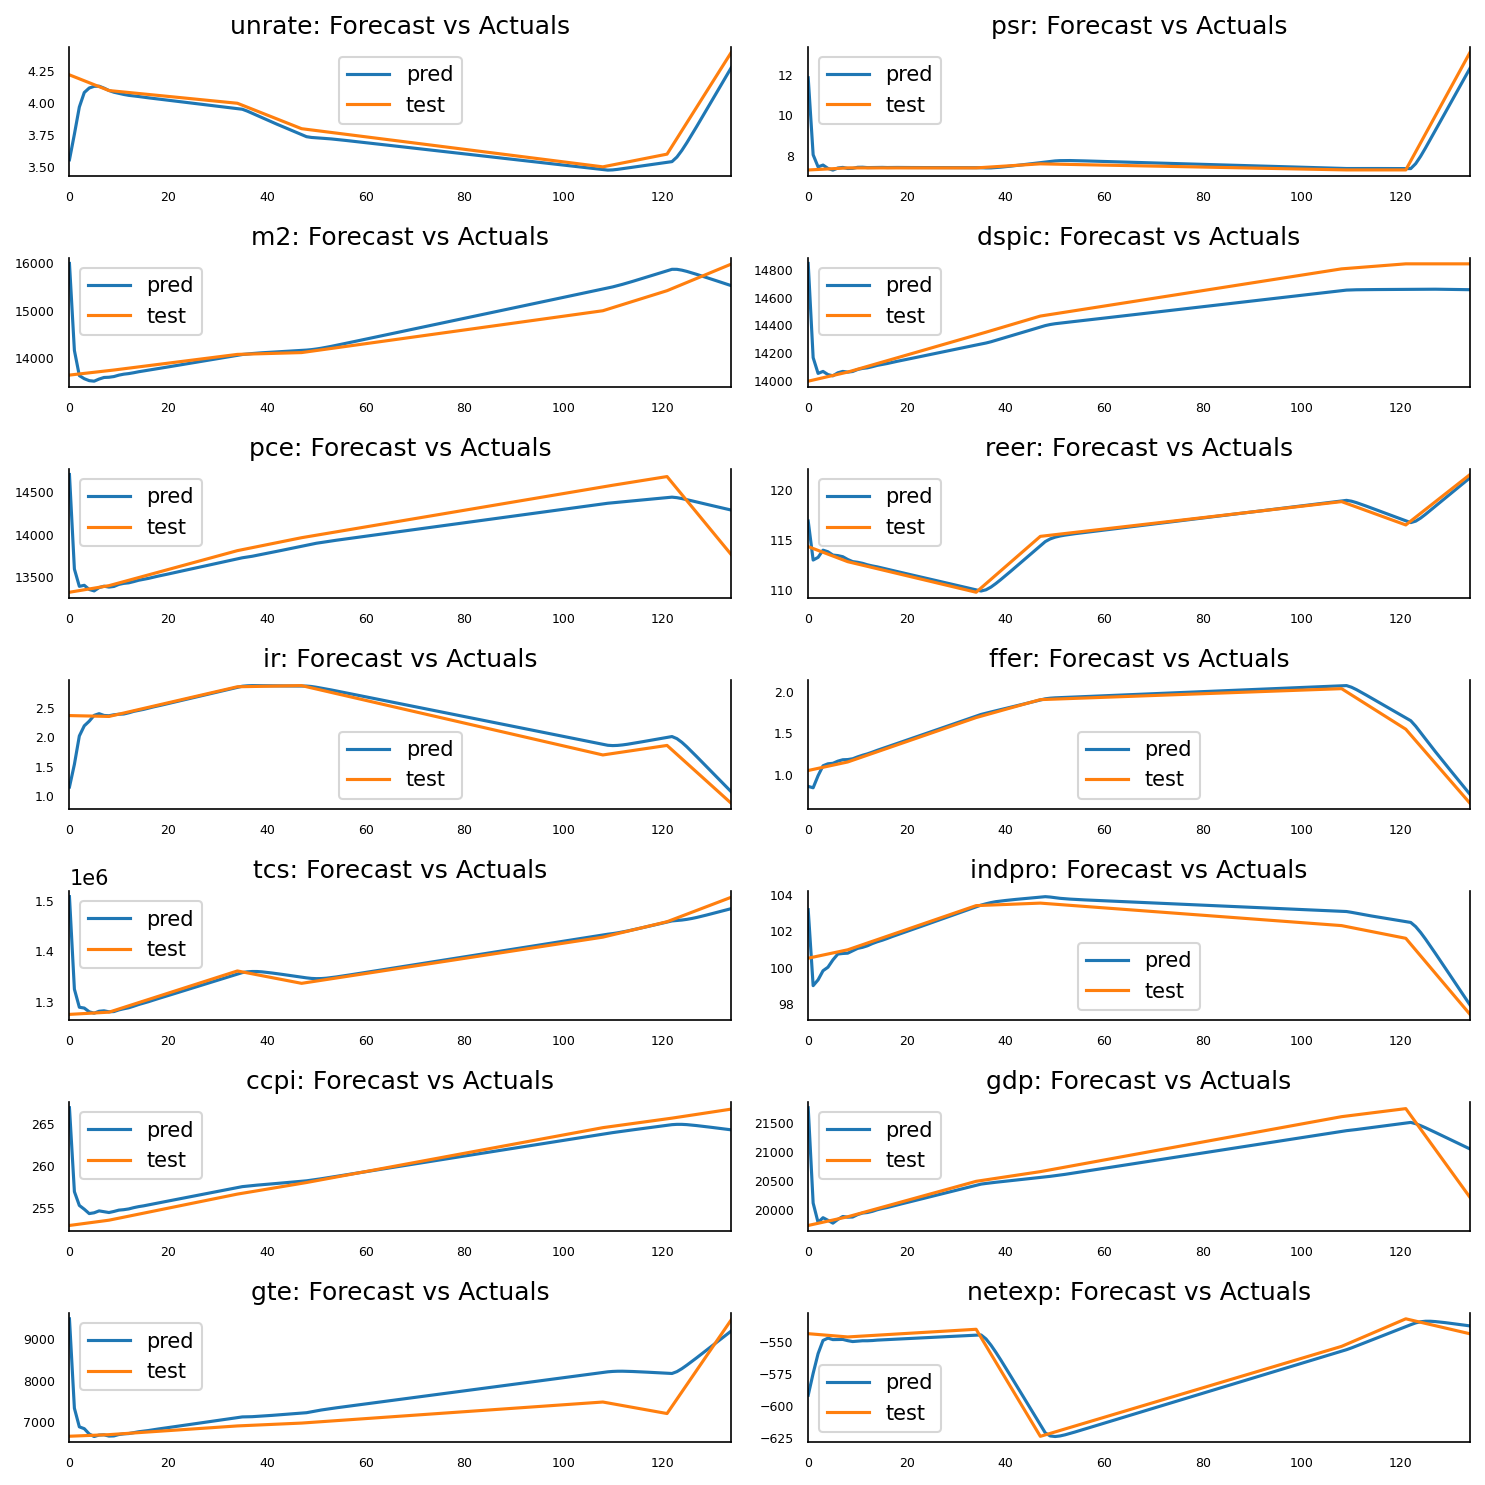

In [141]:
%%time
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Nadam


def build_model_GRU(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(GRU(hout, input_shape=(npas,icol)))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol + int((hout - icol) * 0.5)))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Nadam(learning_rate=1e-3))
    return grid_model

#grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
grid_model = build_model_GRU(npas, hout, p)
'''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''
grid_fit = grid_model.fit(trainX,trainY,epochs=30,batch_size=64,verbose=1)
prediction=grid_model.predict(testX)
testY_reverse, prediction_reverse = scaler.inverse_transform(testY), scaler.inverse_transform(prediction)
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=testY_reverse[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [142]:
validate(testY_reverse, prediction_reverse)

MSE: 33298072.341881346
RMSE: 5770.4481924614265
MAE: 572.6749616708055
MAPE: 1.7721784588272782
R2: 0.7653978740651206


Несколько лучше, чем LSTM; в остальном - всё то же самое.

UPD. Добавил эпох (10 -> 30), изменил оптимизатор (Adam -> Nadam) и увеличил размерность выхода реккурентного слоя (1500 -> 2500). R2 стал заметно лучше, и теперь он довольно неплохой.

Заключение: хоть R2 на нейронных сетях и оказались невысоки, имеющиеся результаты уже довольно неплохи, демонстрируя гораздо меньший MAPE, чем на классических моделях. Модели пришлось остановить на 10 эпохах, чтобы обучение не шло несколько часов, однако во всех трёх случаях обучение останавливалось до того, как лосс прекращал уменьшаться, так что можно предположить, что при большем количестве эпох можно было бы увидеть отличный результат на всех метриках. Кроме того, для нейронных сетей не важна стационарность ряда, так что в копилке плюсов нейронных сетей пополнение. Так что между нейронными сетями и классическими моделями я выбрал бы первое.

UPD. Изменив оптимизатор, а также увеличив число эпох и увеличив размерность выхода реккурентного слоя, мне удалось добиться приличного r2 на GRU.